# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
sns.set()

from collections import Counter
from tqdm.notebook import tqdm
tqdm.pandas()

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional, GlobalMaxPooling1D

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2, RFE, SelectFromModel, SelectKBest
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression

from sklearn.ensemble import (
    BaggingClassifier,
    StackingClassifier,
    AdaBoostClassifier, 
    ExtraTreesClassifier,
    RandomForestClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from pycaret.classification import ClassificationExperiment



# 2. Load Data

In [125]:
data = pd.read_csv('../Dataset/earthquake.csv')
data = data.drop(columns=['ID','Depth', 'Depth Error', 'Depth Seismic Stations', 'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap', 'Horizontal Distance', 'Horizontal Error', 'Root Mean Square'])
data = data.dropna()
data

,Date,Time,Latitude,Longitude,Type,Magnitude,Magnitude Type,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.2460,145.6160,Earthquake,6.0,MW,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.8630,127.3520,Earthquake,5.8,MW,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.5790,-173.9720,Earthquake,6.2,MW,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.0760,-23.5570,Earthquake,5.8,MW,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.9380,126.4270,Earthquake,5.8,MW,ISCGEM,ISCGEM,ISCGEM,Automatic
...,...,...,...,...,...,...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,Earthquake,5.6,ML,NN,NN,NN,Reviewed
23408,12/28/2016,09:13:47,38.3777,-118.8957,Earthquake,5.5,ML,NN,NN,NN,Reviewed
23409,12/28/2016,12:38:51,36.9179,140.4262,Earthquake,5.9,MWW,US,US,US,Reviewed
23410,12/29/2016,22:30:19,-9.0283,118.6639,Earthquake,6.3,MWW,US,US,US,Reviewed


# 3. Initial Analysis

### 3.1. Metadata

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23409 entries, 0 to 23411
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Time              23409 non-null  object        
 1   Latitude          23409 non-null  float64       
 2   Longitude         23409 non-null  float64       
 3   Type              23409 non-null  object        
 4   Magnitude         23409 non-null  float64       
 5   Magnitude Type    23409 non-null  object        
 6   ID                23409 non-null  object        
 7   Source            23409 non-null  object        
 8   Location Source   23409 non-null  object        
 9   Magnitude Source  23409 non-null  object        
 10  Status            23409 non-null  object        
 11  date              23409 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 2.3+ MB


In [10]:
data.isnull().sum()

Date                0
Time                0
Latitude            0
Longitude           0
Type                0
Magnitude           0
Magnitude Type      0
ID                  0
Source              0
Location Source     0
Magnitude Source    0
Status              0
dtype: int64

In [11]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Latitude,23409.0,1.674322,30.112233,-77.080,-18.6560,-3.570,26.158,86.005
Longitude,23409.0,39.660642,125.506701,-179.997,-76.3113,103.993,145.027,179.998
Magnitude,23409.0,5.882553,0.423087,5.500,5.6000,5.700,6.000,9.100


In [12]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 0


In [85]:
data.nunique()

Date                12401
Time                20469
Latitude            20673
Longitude           21471
Type                    4
Magnitude              64
Magnitude Type         10
Source                 12
Location Source        47
Magnitude Source       23
Status                  2
dtype: int64

[Text(0, 0, '1906'),
 Text(0, 0, '1777'),
 Text(0, 0, '1944'),
 Text(0, 0, '1722'),
 Text(0, 0, '1406'),
 Text(0, 0, '1544')]

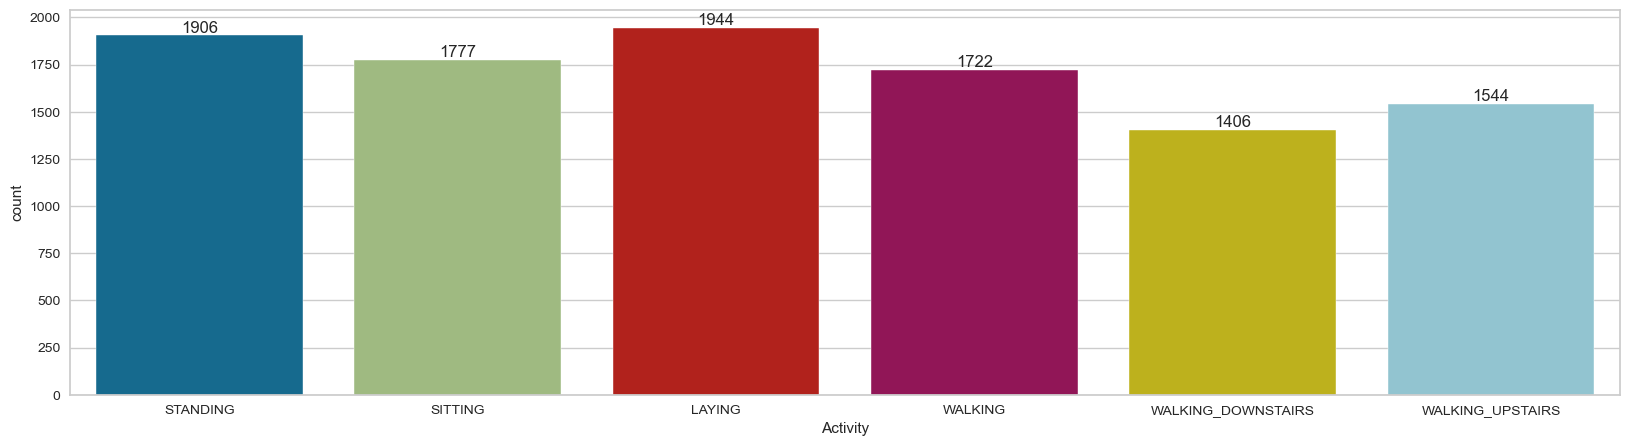

In [15]:
plt.subplots(figsize=(20,5))
ax = sns.countplot(data, x=data['Activity'])
ax.bar_label(ax.containers[0])

### 3.2. Get columns dtypes

In [123]:
from datetime import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        if ts.year < 1970:
            timestamp.append('TimestampError')
        else:
            timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        timestamp.append('ValueError')
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values
data = data.drop(['Date', 'Time'], axis=1)
data = data[data.Timestamp != 'ValueError']
data = data[data.Timestamp != 'TimestampError']
data.head()

,Latitude,Longitude,Type,Magnitude,Magnitude Type,Source,Location Source,Magnitude Source,Status,Timestamp
1456,-29.400,-177.169,Earthquake,5.6,MW,ISCGEM,ISCGEM,ISCGEM,Automatic,36660.0
1457,24.185,102.543,Earthquake,7.1,MW,ISCGEM,ISCGEM,ISCGEM,Automatic,295241.0
1458,23.984,102.732,Earthquake,5.9,MW,ISCGEM,ISCGEM,ISCGEM,Automatic,362950.0
1459,-9.583,151.493,Earthquake,6.3,MW,ISCGEM,ISCGEM,ISCGEM,Automatic,426954.0
1460,15.785,-59.808,Earthquake,6.0,MW,ISCGEM,ISCGEM,ISCGEM,Automatic,521774.0


In [99]:
# data['datetime'] = pd.to_datetime(data['Date'])
# data['date'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d', utc=True).dt.date
# data['date'] = data['date'].astype('datetime64[ns]')

# data['Time'] = pd.to_datetime(data['Time'], utc=True)
# data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.time

# data = data.drop(columns=['Date', 'datetime'])

In [128]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Magnitude', 'Magnitude Type', 'Source', 'Location Source', 'Magnitude Source', 'Status']
Categorical Columns : []


In [127]:
def change_columns_to_numerical(data):
    LE = LabelEncoder()

    # columns = ['Type', 'Magnitude Type', 'Source', 'Location Source', 'Magnitude Source', 'Status']

    for column in categorical_columns:
        data[column] = LE.fit_transform(data[column])
        print(f'{column} : {LE.classes_}') 
    return data

data = change_columns_to_numerical(data)

Date : ['01/01/1967' '01/01/1969' '01/01/1970' ... '1975-02-23T02:58:41.000Z'
 '1985-04-28T02:53:41.530Z' '2011-03-13T02:23:34.520Z']
Time : ['00:00:03' '00:00:04' '00:00:09' ... '23:59:44' '23:59:46' '23:59:58']
Type : ['Earthquake' 'Explosion' 'Nuclear Explosion' 'Rock Burst']
Magnitude Type : ['MB' 'MD' 'MH' 'ML' 'MS' 'MW' 'MWB' 'MWC' 'MWR' 'MWW']
Source : ['AK' 'CI' 'GCMT' 'ISCGEM' 'ISCGEMSUP' 'NC' 'NN' 'OFFICIAL' 'PR' 'SE' 'US'
 'UW']
Location Source : ['AEI' 'AEIC' 'AG' 'AGS' 'AK' 'ATH' 'B' 'BEO' 'BOU' 'BRK' 'CAR' 'CASC'
 'CI' 'CSEM' 'G' 'GCMT' 'GUC' 'H' 'HVO' 'ISCGEM' 'ISK' 'JMA' 'LIM' 'MDD'
 'NC' 'NN' 'OTT' 'PGC' 'PR' 'ROM' 'RSPR' 'SE' 'SJA' 'SLC' 'SPE' 'TAP'
 'TEH' 'THE' 'THR' 'TUL' 'U' 'UCR' 'UNM' 'US' 'US_WEL' 'UW' 'WEL']
Magnitude Source : ['1000' '1009' '1020' '1023' 'AK' 'BRK' 'CI' 'GCMT' 'GUC' 'HRV' 'ISCGEM'
 'NC' 'NIED' 'NN' 'OFFICIAL' 'PAR' 'PGC' 'PR' 'SE' 'US' 'US_GCMT' 'US_PGC'
 'UW']
Status : ['Automatic' 'Reviewed']


### 3.3. EDA

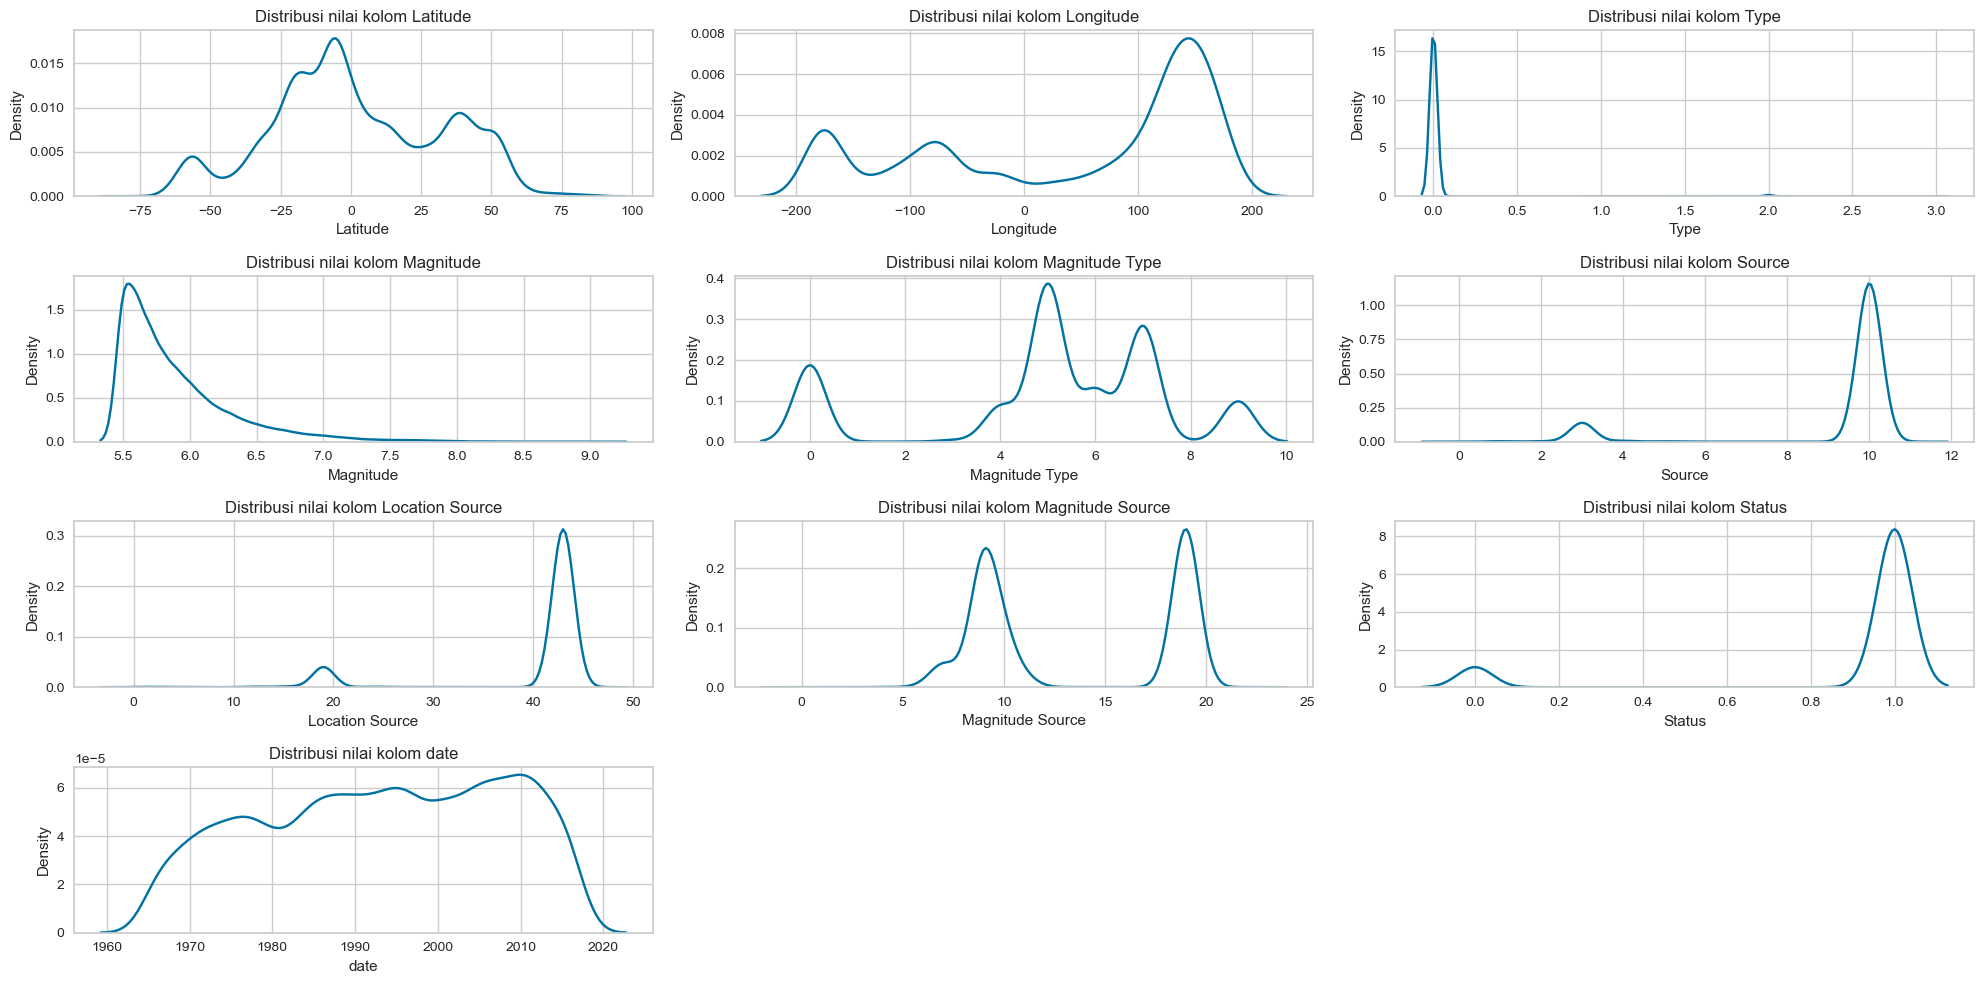

In [106]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="satisfaction", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Price Range', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

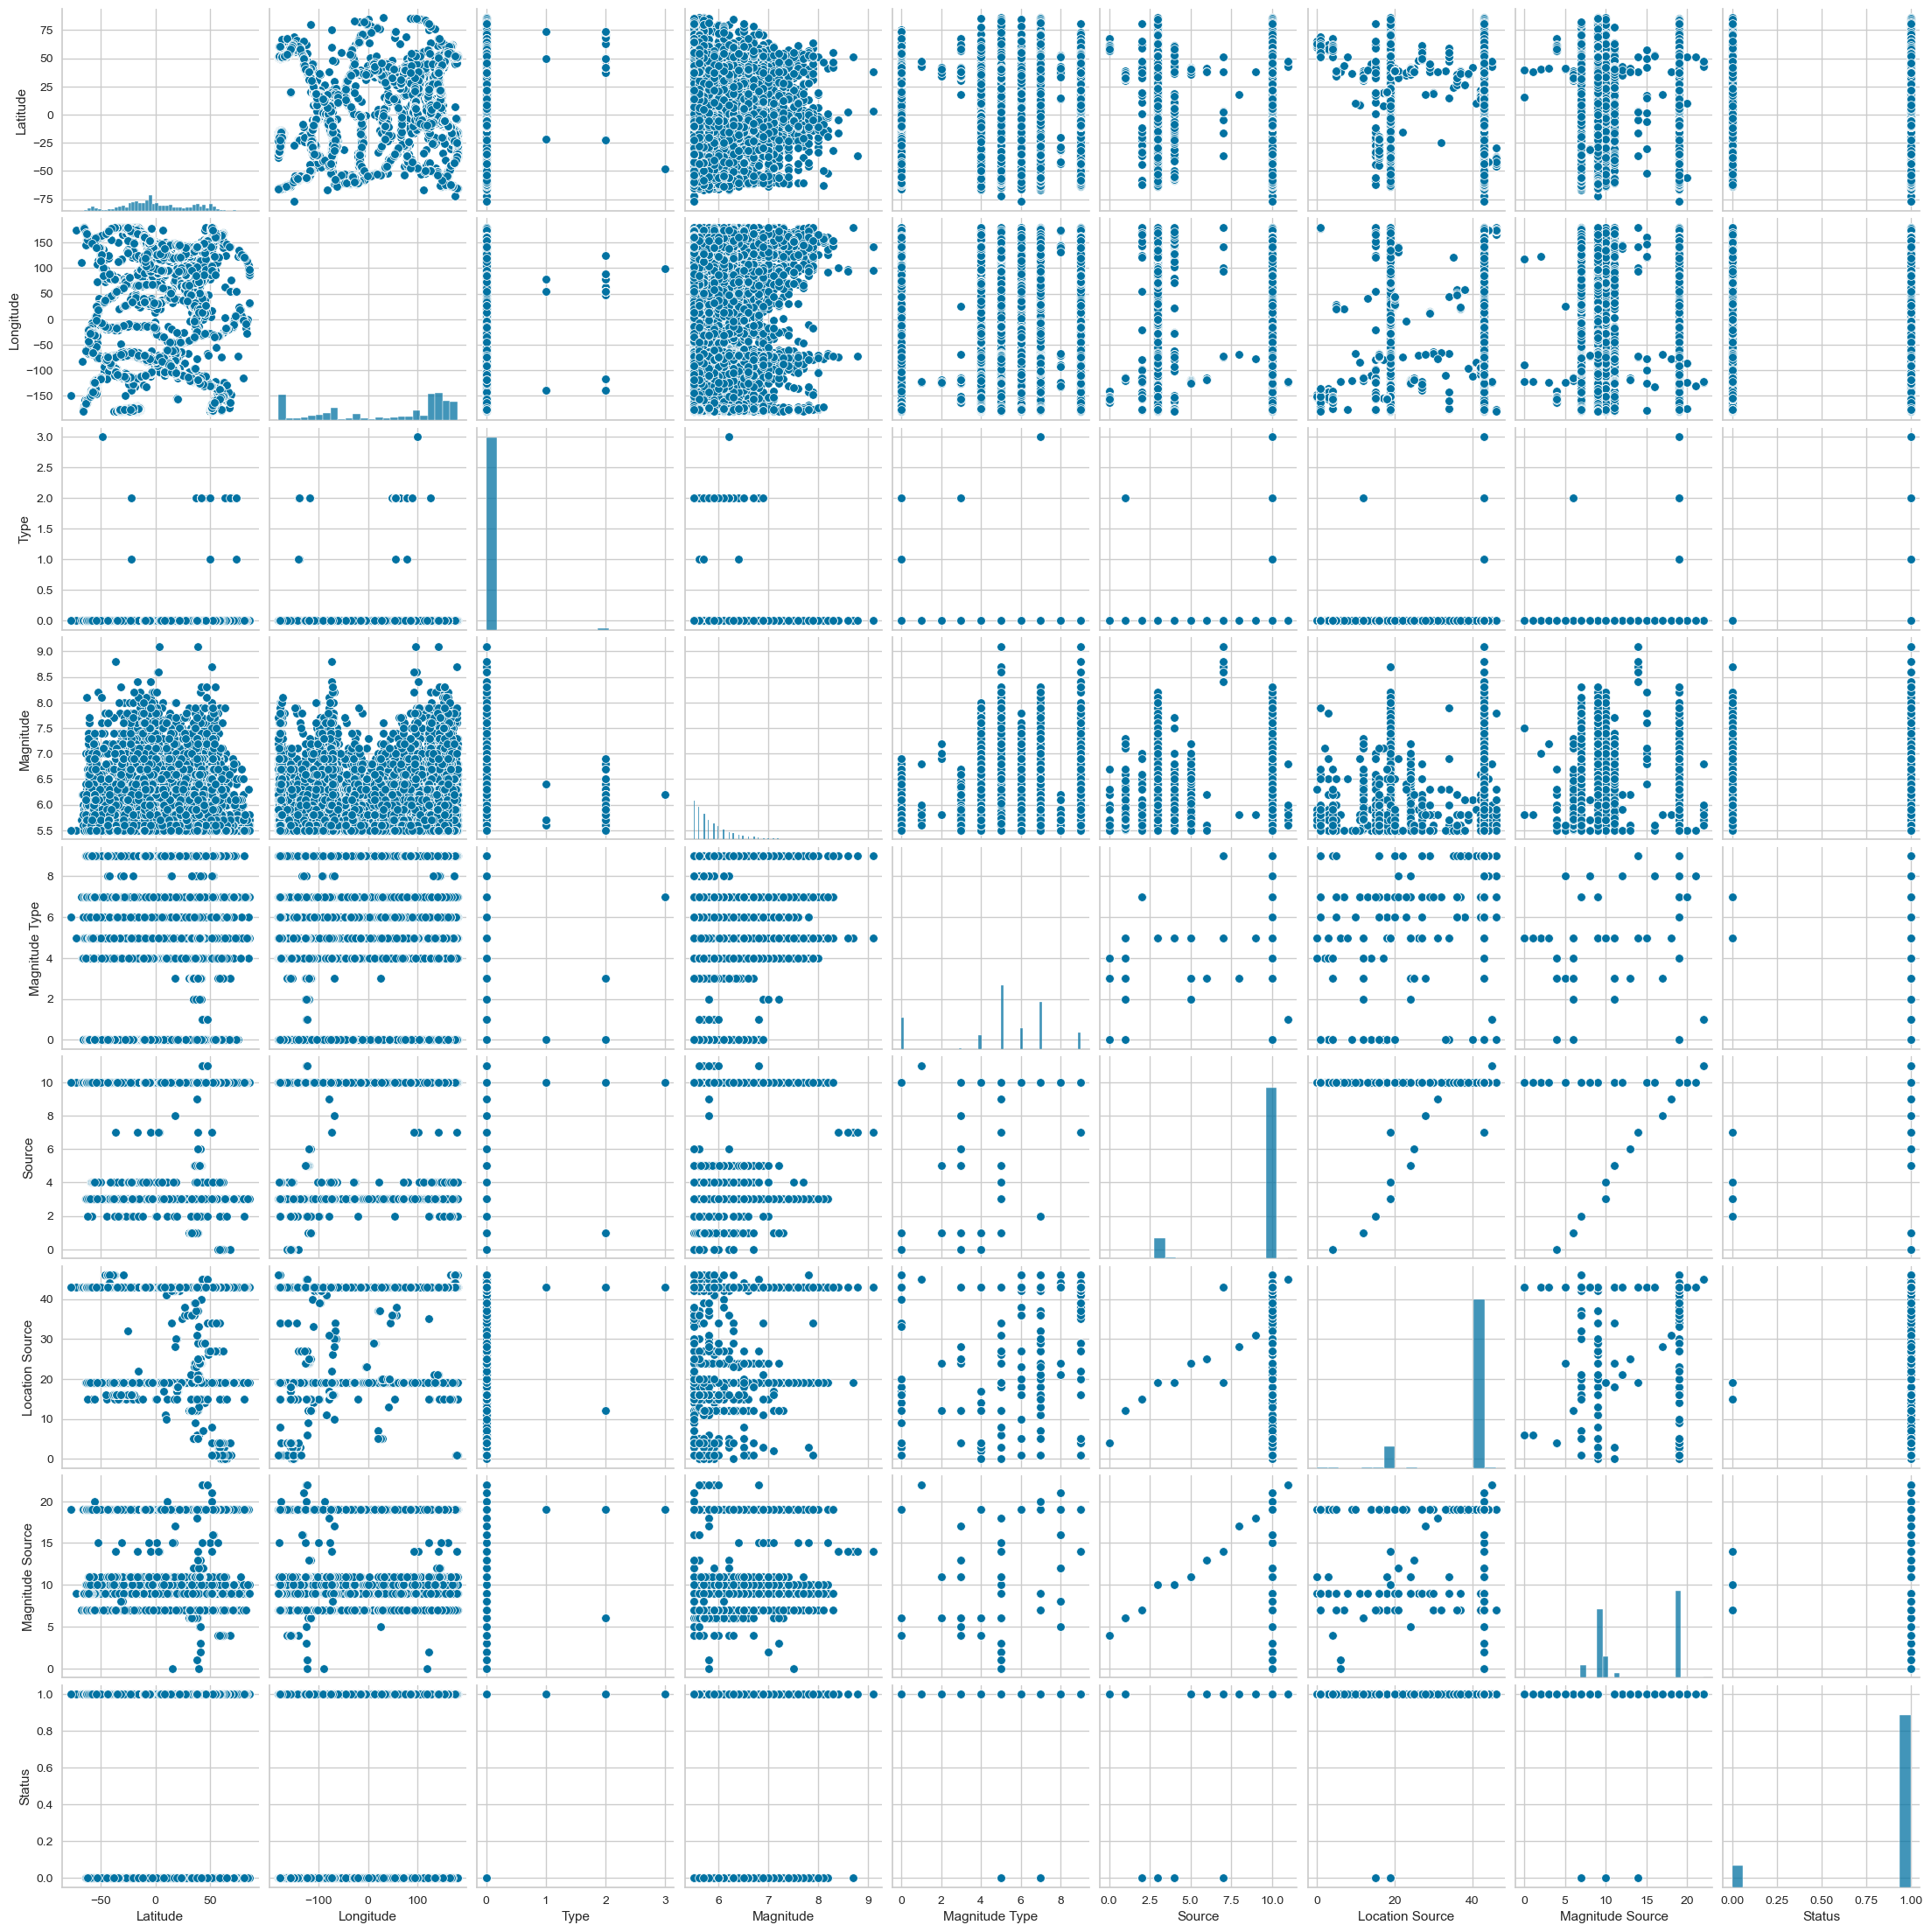

In [107]:
sns.pairplot(data)

In [ ]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'Activity', palette='YlOrBr')
ax.bar_label(ax.containers[0])

In [ ]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Diabetics', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

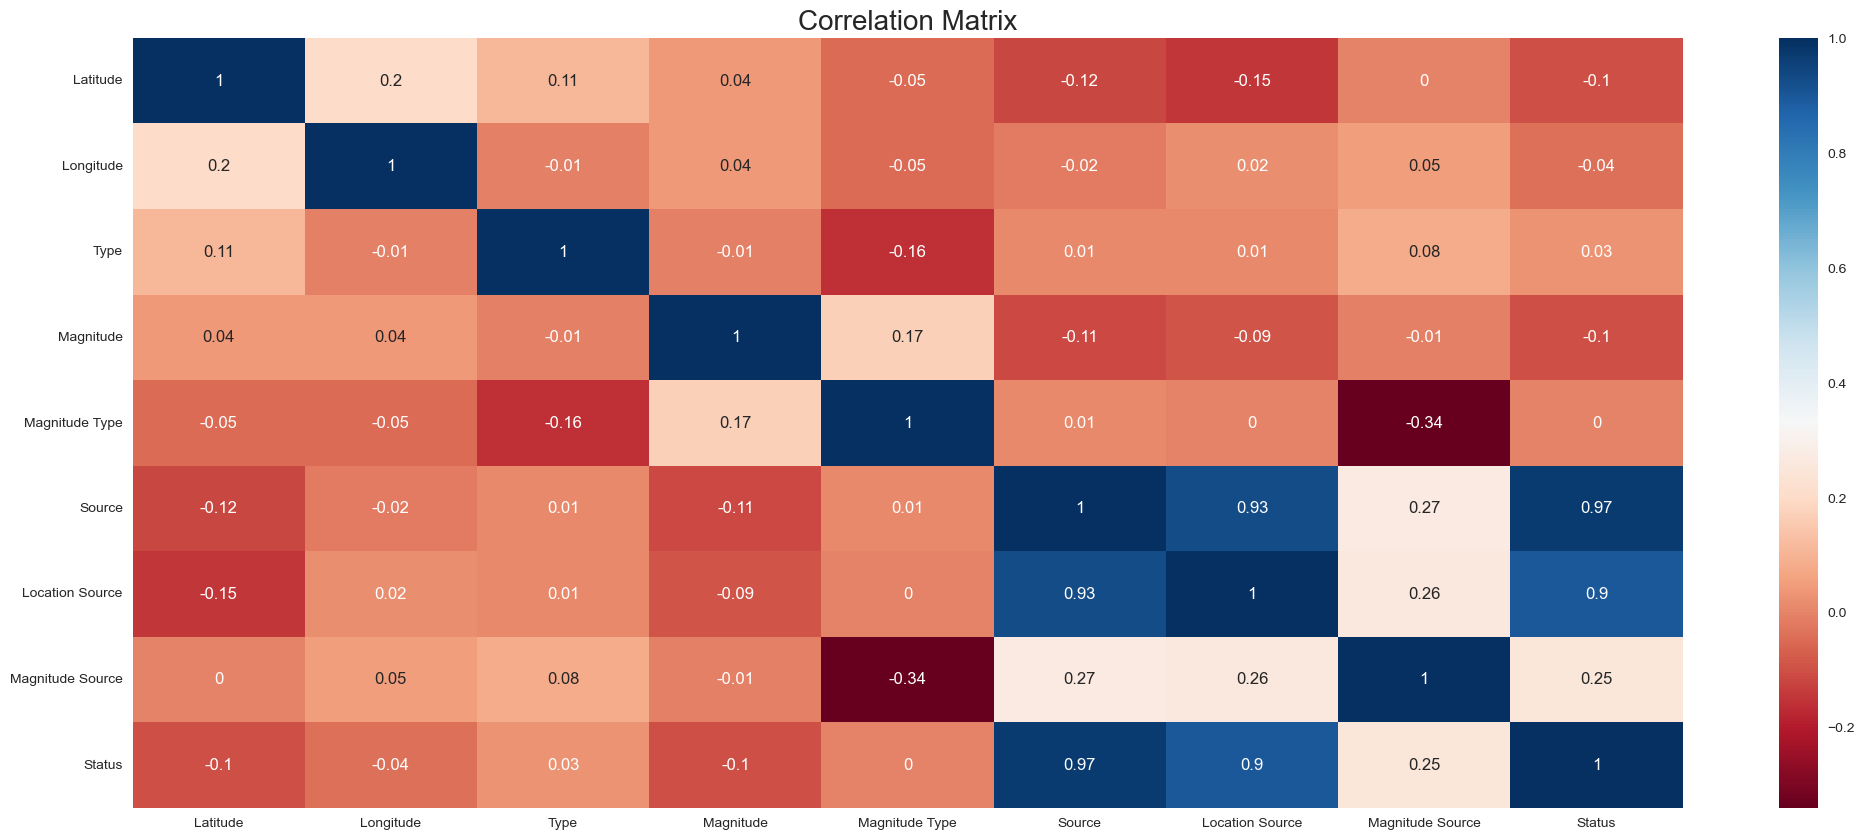

In [109]:
corr_data = data[numerical_columns].corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


# 5 Neural Network Algoritms

In [129]:
X = data.drop(columns=['Magnitude'])
Y = data['Magnitude']

# print(Counter(Y))
# sampling = RandomUnderSampler()
# # sampling = SMOTE()
# X, Y = sampling.fit_resample(X, Y)
# print(Counter(Y))

Y = pd.get_dummies(Y).values

# scaler = MinMaxScaler(feature_range=(0,1))
# scaler = PowerTransformer(method='yeo-johnson', standardize=True)
# X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

label = y_train.shape[1]

(16433, 10)
(4635, 10)
(2341, 10)


In [130]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(4096, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1],)))
    # model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(Dense(label, activation='softmax'))
    
    return model

def CNN_Model():
    model = Sequential()

    model.add(Conv1D(128, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.8))
    model.add(MaxPooling1D())

    # model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    # model.add(Conv1D(16, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(label, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add((LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add((LSTM(256)))
    # model.add(Dense(32, activation='swish'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(label, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(label, activation='softmax'))
    return model
    

model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.000_1)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 4096)              45056     
                                                                 
 dense_10 (Dense)            (None, 1000)              4097000   
                                                                 
 dense_11 (Dense)            (None, 64)                64064     
                                                                 
Total params: 4,206,120
Trainable params: 4,206,120
Non-trainable params: 0
_________________________________________________________________


In [131]:
num_epoch = 10
batch_size = 32

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_test, y_test))

Epoch 1/10
514/514 [==============================] - 3s 5ms/step - loss: 88.3634 - accuracy: 0.1152 - val_loss: 66.2311 - val_accuracy: 0.0932
Epoch 2/10
514/514 [==============================] - 2s 4ms/step - loss: 51.5206 - accuracy: 0.1188 - val_loss: 51.6833 - val_accuracy: 0.1338
Epoch 3/10
514/514 [==============================] - 2s 4ms/step - loss: 35.6979 - accuracy: 0.1108 - val_loss: 23.2024 - val_accuracy: 0.0813
Epoch 4/10
514/514 [==============================] - 2s 4ms/step - loss: 25.6350 - accuracy: 0.1189 - val_loss: 31.1370 - val_accuracy: 0.1044
Epoch 5/10
514/514 [==============================] - 2s 4ms/step - loss: 18.1674 - accuracy: 0.1146 - val_loss: 16.3184 - val_accuracy: 0.1070
Epoch 6/10
514/514 [==============================] - 2s 4ms/step - loss: 14.0868 - accuracy: 0.1252 - val_loss: 9.4223 - val_accuracy: 0.1625
Epoch 7/10
514/514 [==============================] - 2s 4ms/step - loss: 10.5672 - accuracy: 0.1270 - val_loss: 9.3801 - val_accuracy: 0

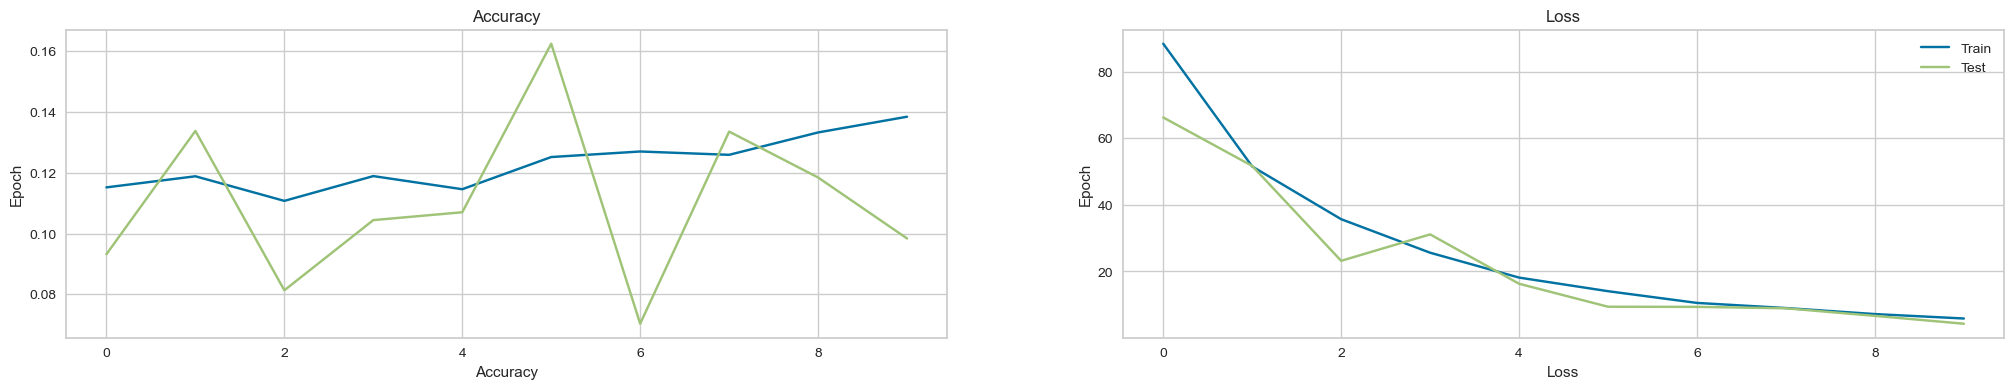

In [132]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [133]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(X_val, verbose=0))

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       469
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.15      0.09      0.11       385
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00       312
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

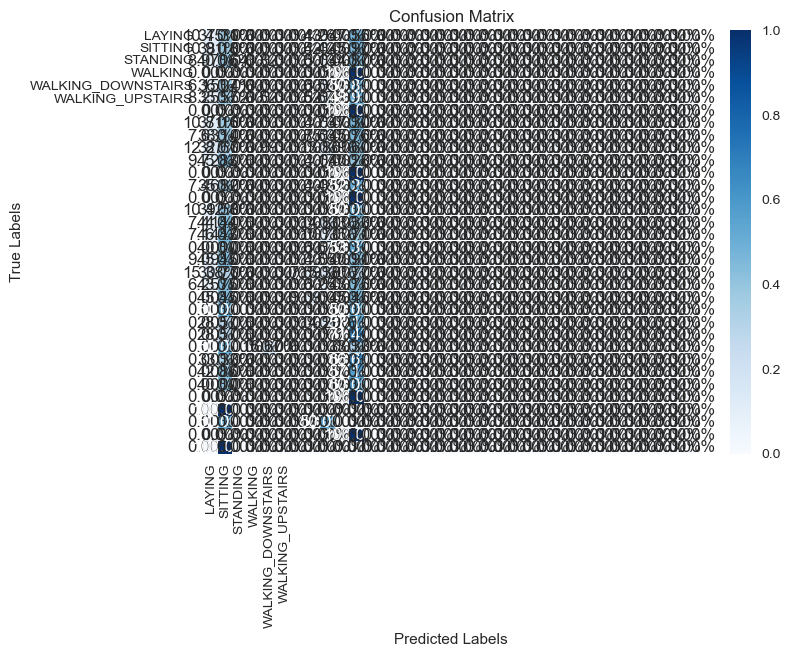

In [134]:
labels = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

y_pred = np.rint(model.predict(X_val, verbose=0).argmax(axis=1))
con_mat = confusion_matrix(y_val.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [39]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

In [40]:

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

: 

: 

# 6. Supervised Learning

In [79]:
X = data.drop(columns=['Activity']).values
Y = data['Activity']

print(Counter(Y))
undersample = RandomUnderSampler()
# undersample = SMOTE()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = Y.values

# scaler = MinMaxScaler(feature_range=(0,1))
# scaler = PowerTransformer(method='yeo-johnson', standardize=True)
# X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9, random_state = 42)

print(X_train.shape)
print(X_test.shape)

Counter({'LAYING': 1944, 'STANDING': 1906, 'SITTING': 1777, 'WALKING': 1722, 'WALKING_UPSTAIRS': 1544, 'WALKING_DOWNSTAIRS': 1406})
Counter({'LAYING': 1406, 'SITTING': 1406, 'STANDING': 1406, 'WALKING': 1406, 'WALKING_DOWNSTAIRS': 1406, 'WALKING_UPSTAIRS': 1406})
(7592, 562)
(844, 562)


### 6.2 Stacking Classifier

In [80]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradient = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
pac = PassiveAggressiveClassifier(random_state=42)
linear = LogisticRegression(random_state=42)

model = StackingClassifier([
    ('bagging', bagging),
    ('adaboost', adaboost),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('decisionTree', decisionTree),
    ('histGradient', histGradient),
    ('XGB', XGB),
    ('pac', pac),
    ('linear', linear),
    # ('gradient', gradient),
    # ('knn', knn),
], n_jobs=-1)

In [81]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                               ('randomforest',
                                RandomForestClassifier(max_depth=100, n_jobs=-1,
                                                       random_state=42)),
                               ('decisionTree',
                                DecisionTreeClassifier(max_depth=100,
                                                       r...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('pac',
                                PassiveAggressiveClassifier(random_state=42)),
                               ('linear', LogisticRegression(random_state=42))],
                   n_jobs=-1)

In [82]:
print("Train Score : ",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score  : ",round((model.score(X_test, y_test)*100), 2),'%')

Train Score :  100.0 %
Test Score  :  99.41 %


In [84]:
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       153
           SITTING       0.98      0.99      0.99       126
          STANDING       0.99      0.99      0.99       136
           WALKING       0.99      1.00      0.99       139
WALKING_DOWNSTAIRS       1.00      0.99      1.00       134
  WALKING_UPSTAIRS       1.00      0.99      1.00       156

          accuracy                           0.99       844
         macro avg       0.99      0.99      0.99       844
      weighted avg       0.99      0.99      0.99       844



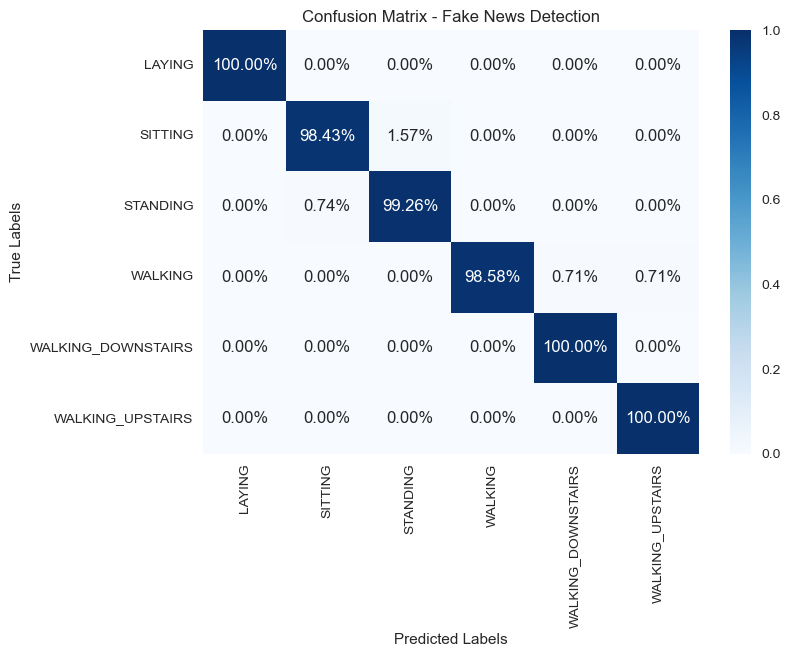

In [85]:
labels = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

y_pred = model.predict(X_test)
con_mat = confusion_matrix(y_test,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

### 6.2. Pycaret

In [86]:
s = ClassificationExperiment()
s.setup(data, target = 'Activity', session_id = 123)

In [35]:
best = s.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:47:23
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [ ]:
s.evaluate_model(best)
print(best)

In [ ]:
s.predict_model(best)

In [12]:
lgbm = s.create_model('xgboost')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:02:50
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7718,0.8167,0.7180,0.7497,0.7335,0.5342,0.5346
1,0.7747,0.8213,0.7183,0.7547,0.7360,0.5396,0.5401
2,0.7757,0.8226,0.7208,0.7552,0.7376,0.5419,0.5424
3,0.7683,0.8147,0.7119,0.7465,0.7288,0.5267,0.5272
4,0.7714,0.8189,0.7178,0.7491,0.7331,0.5334,0.5337
5,0.7700,0.8144,0.7148,0.7482,0.7311,0.5304,0.5308
6,0.7762,0.8220,0.7227,0.7552,0.7386,0.5432,0.5436
7,0.7739,0.8207,0.7208,0.7520,0.7361,0.5385,0.5389
8,0.7744,0.8216,0.7189,0.7538,0.7360,0.5392,0.5397


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
X = data.drop(columns=['satisfaction']).values
Y = data['satisfaction']

In [37]:
scores = cross_val_score(lgbm, X_train, y_train, cv=20)

NameError: name 'X_train' is not defined

<Axes: >

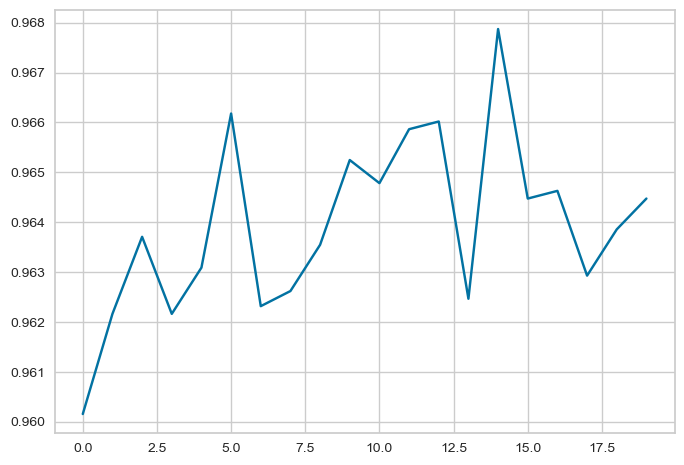

In [22]:
sns.lineplot(scores)

In [16]:
preds = s.predict_model(lgbm)
preds

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7745,0.8197,0.7199,0.7531,0.7362,0.5394,0.5399


In [36]:
pred = (abs(preds['satisfaction'] - preds['prediction_label'])).sum()

print(f'{pred} / {preds.shape[0]} : {round(pred/preds.shape[0]*100, 2)} % (False Predictions)')

33248 / 147438 : 22.55 % (False Predictions)
